In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as nplin
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')

In [3]:
logging.basicConfig(filename='convergence.tmp.log', level=logging.INFO)
logging.captureWarnings(True)

## Setup the True Parameters /  Simulation Parameters

## Setup the linking functions.

In [4]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.gamma(rho=true_params['rho'], scale=true_params['scale'], delta=true_params['delta'], 
                       phi=true_params['phi'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['vol_price'], theta=true_params['equity_price']),
     'psi':vl.psi(true_params['rho'], true_params['scale'], true_params['phi'], 
                  theta=true_params['equity_price']), 
     'phi_squared': true_params['phi']**2})

NameError: name 'true_params' is not defined

## We start by examining the distributions of simulated data

In [ ]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [ ]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()


In [ ]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [ ]:
data.describe()

## I now estimate all of the parameters

In [117]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'phi':-.17,
               'scale': .1,
               'delta': 1,
               'rho': .5,
              }
time_dim = 5000
sim_dim = 1000

In [118]:
results = np.arange(sim_dim)

In [119]:
data = vl.simulate_data(time_dim=time_dim, **true_params)


In [120]:
vol_data = vl.simulate_autoregressive_gamma(delta=1, rho=0, scale=1,time_dim=time_dim)


In [121]:
def get_data_and_results(x):
    data = vl.simulate_data(time_dim=time_dim, **true_params)
    init_constants = vl.compute_init_constants(data.vol)
    vol_est = vl.compute_vol_gmm(data.vol, init_constants=init_constants)
    return data, vol_est

In [122]:
# with Pool(8) as pool:
data_arr, est_arr = zip(*[result  for result in tqdm.tqdm_notebook(
    map(get_data_and_results, results), total=len(results))])

In [123]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean   / np.sqrt(np.diag(cov) / data.vol.size)

In [138]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'], rho=true_params['rho'], 
                scale=true_params['scale'])) for data in tqdm.tqdm_notebook(data_arr)])

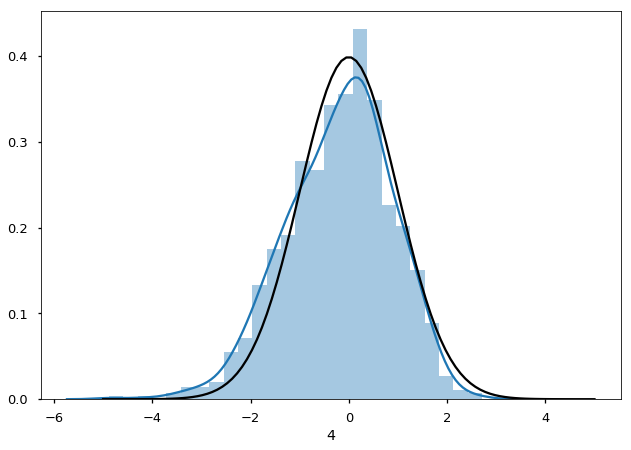

In [148]:
moment_fig, moment_ax = mpl.pyplot.subplots()
sns.distplot(moment_data.iloc[:,4], ax=moment_ax)
moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

In [151]:
data_arr[0].vol.apply(np.square).mean()

0.07818433922327334

In [149]:
vl.vol_moments_grad(data_arr[0].vol, true_params['delta'], true_params['rho'], true_params['scale'])

,delta,rho,scale
0,0.100000,0.196970,1.000000
1,0.019697,0.078200,0.196970
2,0.049697,0.156988,0.793940
3,0.013729,0.077072,0.235188
4,0.006925,0.052609,0.122864


Text(0.5,0,'delta')

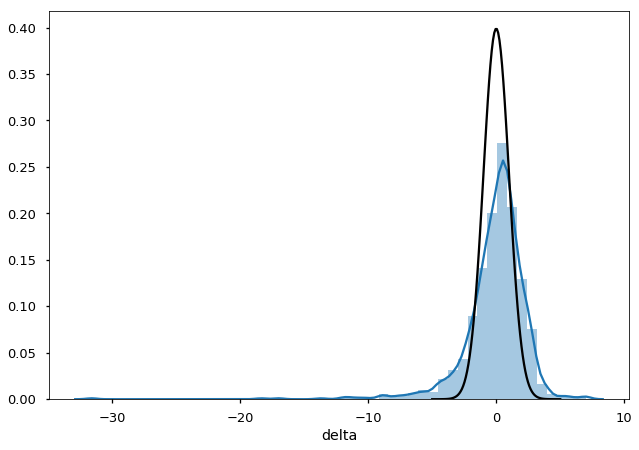

In [125]:
delta_fig, delta_ax = mpl.pyplot.subplots()
sns.distplot([(est['delta'] - true_params['delta']) / np.sqrt(cov.loc['delta','delta']) 
              for est, cov in est_arr], ax=delta_ax)
delta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
delta_ax.set_xlabel('delta')

Text(0.5,0,'scale')

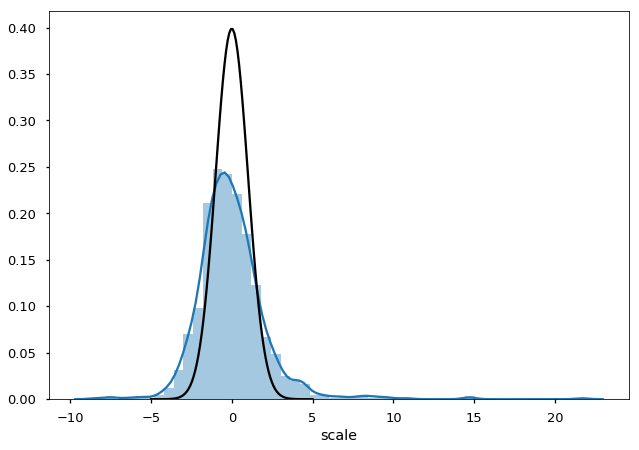

In [126]:
scale_fig, scale_ax = mpl.pyplot.subplots()
sns.distplot([(est['scale'] - true_params['scale']) / np.sqrt(cov.loc['scale', 'scale']) 
              for est, cov in est_arr], ax=scale_ax)
scale_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
scale_ax.set_xlabel('scale')

Text(0.5,0,'rho')

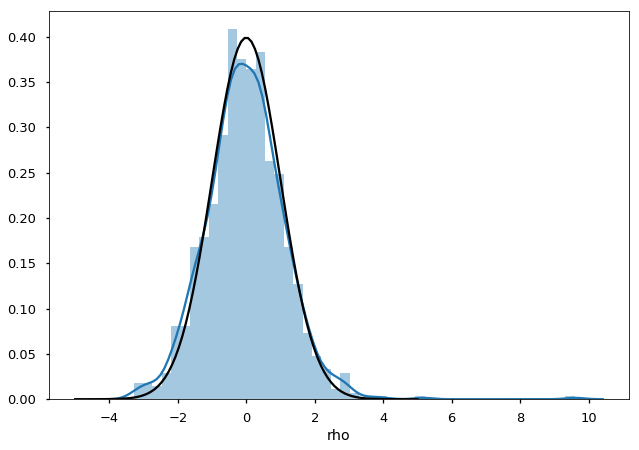

In [127]:
rho_fig, rho_ax = mpl.pyplot.subplots()
sns.distplot([(est['rho'] - true_params['rho']) / np.sqrt(cov.loc['rho', 'rho']) 
              for est, cov in est_arr], ax=rho_ax)
rho_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
rho_ax.set_xlabel('rho')

In [128]:
vol_tables = [vl.create_est_table(estimates=est, truth=total_true_params, cov=cov)
                 for est,cov in vol_est_arr]

NameError: name 'vol_est_arr' is not defined

In [87]:
pd.DataFrame([frame.truth - frame.estimate for frame in vol_tables]).mean(axis=0)

NameError: name 'vol_tables' is not defined

In [ ]:
stage2_estimates, stage2_cov = vl.estimate_params(data)


In [ ]:
vl.create_est_table(estimates=stage2_estimates, truth=total_true_params, cov=stage2_cov)

In [ ]:
vl.cov_to_corr(stage2_cov)